## Setup Packages
Recommended to use [Anaconda](https://www.anaconda.com/l) in combination with an environment. Installation commands for all required packages can be found below. Choose the installation command that fits your setup.

In [1]:
# With Anaconda with GPU
!conda install ipykernel requests pandas numpy scikit-learn nltk matplotlib graphviz python-graphviz torchinfo pytorch torchvision torchaudio cudatoolkit=11.3 -c pytorch
!pip install wget yfinance hiddenlayer

# With Anaconda with CPU (no GPU support)
# !conda install ipykernel requests pandas numpy scikit-learn nltk matplotlib graphviz python-graphviz pytorch torchvision torchaudio cpuonly -c pytorch
# !pip install wget yfinance hiddenlayer

# Without Anaconda with GPU
# !pip install wget yfinance hiddenlayer ipykernel requests pandas numpy scikit-learn nltk matplotlib graphviz torch==1.10.1+cu113 torchvision==0.11.2+cu113 torchaudio===0.10.1+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

# Without Anaconda with CPU (no GPU support)
# !pip install wget yfinance hiddenlayer ipykernel requests pandas numpy scikit-learn nltk matplotlib graphviz torch torchvision torchaudio

^C


## Datasets
Select and download datasets.  
  
All downloads are hosted on own Nextcloud server for consistently good performance. For dataset references please see links below.

Available datasets:  
[0](http://help.sentiment140.com/for-students) - 1,600,000 automatically labelled tweets.  
[1](https://nlp.stanford.edu/sentiment/code.html) - 10,605 manually labelled Rotten Tomatoes reviews.  
[2](https://ieee-dataport.org/open-access/stock-market-tweets-data#files) - 1,300 manually labelled financial tweets.  
[3](https://arxiv.org/abs/1307.5336) - 4,840 manually labelled fiancial news headlines.  
[4](https://github.com/ajayshewale/Sentiment-Analysis-of-Text-Data-Tweets-) - 5,970 manually labelled financial tweets.

In [18]:
import wget, os

# Select databases you want to use for training the model
DATASETS_SELECTED = [1,2,3,4]

all_urls = ["https://nextcloud.lucashost.nl/s/QEDjzxCQidDZDR4/download/trainingandtestdata.zip", "https://nextcloud.lucashost.nl/s/e5tyPSHs9Lrc3bT/download/stanfordSentimentTreebank.zip", "https://nextcloud.lucashost.nl/s/bm8bqeKqdyFqiTe/download/tweets.zip", "https://nextcloud.lucashost.nl/s/2b4tNYKQp9jP7Bn/download/archive.zip", "https://nextcloud.lucashost.nl/s/tdC65kRGWzYzeP2/download/punkt.zip"]
urls = [all_urls[i] for i in DATASETS_SELECTED]
path = "datasets/"

if not os.path.exists(path):
  os.makedirs(path)

for url in urls:
    split_url = url.split("/")
    if not (os.path.exists(path + split_url[-1])):
      wget.download(url, out = path)

In [19]:
import zipfile

for filename in os.listdir(path):
    if filename.endswith(".zip"):
        with zipfile.ZipFile(path + filename, 'r') as zip_ref:
            zip_ref.extractall(path)

Preprocess the differrent datasets and integrate them with eachother.

In [20]:
import pandas as pd
import numpy as np
import math

df = pd.DataFrame()

for i in DATASETS_SELECTED:
    if (i == 0):
        df1_manual = pd.read_csv(path + "testdata.manual.2009.06.14.csv", names=['Sentiment', 'Sentence'], usecols=[0, 5])
        df1_auto = pd.read_csv(path + "training.1600000.processed.noemoticon.csv", names=['Sentiment', 'Sentence'], usecols=[0, 5], encoding='ISO-8859-1')
        df1 = df1_auto.append(df1_manual, ignore_index=True)
        df1["Sentiment"] = df1["Sentiment"].apply(lambda sentiment: "negative" if sentiment == 0 else ("neutral" if sentiment == 2 else "positive"))
        df = df.append(df1, ignore_index=True)
    elif (i ==1):
        df2_sentence = pd.read_csv(path + "stanfordSentimentTreebank/datasetSentences.txt", sep="\t")
        df2_sentiment = pd.read_csv(path + "stanfordSentimentTreebank/sentiment_labels.txt", sep="|")
        df2 = pd.merge(df2_sentence, df2_sentiment, left_on="sentence_index", right_on="phrase ids")
        df2 = df2.drop(columns=["sentence_index", "phrase ids"])
        df2 = df2.rename(columns={"sentiment values": "Sentiment", "sentence": "Sentence"})
        df2["Sentiment"] = df2["Sentiment"].apply(lambda sentiment: "negative" if sentiment < 0.4 else ("neutral" if sentiment <= 0.6 else "positive"))
        df = df.append(df2, ignore_index=True)
    elif (i ==2):
        df3 = pd.read_csv(path + "tweets/tweets_labelled_09042020_16072020.csv", sep=";", on_bad_lines="skip")
        df3 = df3.drop(columns=["id", "created_at"])
        df3 = df3.rename(columns={"sentiment": "Sentiment", "text": "Sentence"})
        df3 = df3.dropna()
        df = df.append(df3, ignore_index=True)
    elif (i == 3):
        df4 = pd.read_csv(path + 'all-data.csv', names=['Sentiment', 'Sentence'], encoding='ISO-8859-1')
        df4['Sentiment'] = df4['Sentiment'].astype('string')
        df4['Sentence'] = df4['Sentence'].astype('string')
        df = df.append(df4, ignore_index=True)
    elif (i == 4):
        df5 = pd.read_csv(path + "train.csv")
        df5 = df5.drop(columns=["Id"])
        df5 = df5.dropna()
        df5 = df5[df5["Tweet"] != "Not Available"]
        df5 = df5[df5["Category"] != "Tweet"]
        df5 = df5.rename(columns={"Category": "Sentiment", "Tweet": "Sentence"})
        df = df.append(df5, ignore_index=True)
    else:
        print("Database " + str(i) + " not found")

df


,Sentence,Sentiment
0,The Rock is destined to be the 21st Century 's...,neutral
1,The gorgeously elaborate continuation of `` Th...,neutral
2,Effective but too-tepid biopic,neutral
3,If you sometimes like to go to the movies to h...,neutral
4,"Emerges as something rare , an issue movie tha...",negative
...,...,...
23417,"Ok ed let's do this, Zlatan, greizmann and Lap...",positive
23418,Goal level: Zlatan 90k by Friday? = Posting e...,neutral
23419,@YouAreMyArsenal Wouldn't surprise me if we en...,neutral
23420,Rib injury for Zlatan against Russia is a big ...,neutral


Normalize sentences.

In [21]:
import re

def normalize_text(sentence):
    link_re_pattern = "https?:\/\/t.co/[\w]+"
    mention_re_pattern = "@\w+"
    enter_re_pattern = "\n"
    sentence = re.sub(link_re_pattern, "", sentence)
    sentence = re.sub(mention_re_pattern, "", sentence)
    sentence = re.sub(enter_re_pattern, " ", sentence)
    return sentence.lower()

df["Sentence"] = df["Sentence"].apply(normalize_text)

Over- and/or undersample sentences.

In [22]:
# How much you oversample compared to undersampling
FACTOR = 0.5

oversample_rate = math.floor((df["Sentiment"].value_counts()[0] - df["Sentiment"].value_counts()[-1]) * FACTOR)
undersample_rate = math.ceil((df["Sentiment"].value_counts()[0] - df["Sentiment"].value_counts()[-1]) * (1 - FACTOR))

most_df = df[df["Sentiment"] == df["Sentiment"].value_counts().index[0]]
mid_df = df[df["Sentiment"] == df["Sentiment"].value_counts().index[1]]
least_df = df[df["Sentiment"] == df["Sentiment"].value_counts().index[2]]

drop_indices = np.random.choice(most_df.index, size=undersample_rate, replace=False)
undersampled = most_df.drop(drop_indices, axis=0)
oversampled = least_df.append(least_df.sample(oversample_rate, replace=True))

midsample_rate = oversampled["Sentiment"].value_counts()[0] - mid_df["Sentiment"].value_counts()[0]

if (midsample_rate < 0):
    mid_drop_indices = np.random.choice(mid_df.index, -midsample_rate, replace=False)
    midsampled = mid_df.drop(mid_drop_indices)
else:
    midsampled = mid_df.append(mid_df.sample(midsample_rate, replace=True))

balanced_df = pd.concat([oversampled, midsampled, undersampled])
balanced_df["Sentiment"].value_counts()

negative    8065
positive    8065
neutral     8065
Name: Sentiment, dtype: int64

Stem sentences with the Porter Stemmer.

In [23]:
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer

USE_STEMMER = True

porter_stemmer  = PorterStemmer()
tokenizer = RegexpTokenizer(r'[\w\d\']+(?![^\s,.\"])')

def tokenization(sentence):
    sentence = tokenizer.tokenize(sentence)
    for idx, word in enumerate(sentence):
        if (USE_STEMMER):
            sentence[idx] = porter_stemmer.stem(word)
        else:
            sentence[idx] = word
    return sentence

balanced_df["Sentence"] = balanced_df["Sentence"].apply(tokenization)

Encoded sentences.

In [24]:
from itertools import islice

index2word = ["<PAD>", "<SOS>", "<EOS>"]

for index, row in balanced_df.iterrows():
    for token in row["Sentence"]:
        if token not in index2word:
                index2word.append(token)

word2index = {token: idx for idx, token in enumerate(index2word)}
print(list(islice(word2index, 50)))

['<PAD>', '<SOS>', '<EOS>', 'emerg', 'as', 'someth', 'rare', 'an', 'issu', 'movi', 'that', "'s", 'so', 'honest', 'and', 'keenli', 'observ', 'it', 'doe', "n't", 'feel', 'like', 'one', 'perhap', 'no', 'pictur', 'ever', 'made', 'ha', 'more', 'liter', 'show', 'the', 'road', 'to', 'hell', 'is', 'pave', 'with', 'good', 'intent', 'thi', 'a', 'film', 'well', 'worth', 'see', 'talk', 'sing', 'head']


In [25]:
def sentiment_map(sentiment):
    if sentiment == "negative":
        return 0
    elif sentiment == "neutral":
        return 1
    else: #positive
        return 2

def encode_and_pad(sentence, length):
    sos = [word2index["<SOS>"]]
    eos = [word2index["<EOS>"]]
    pad = [word2index["<PAD>"]]
    encoded = []

    if len(sentence) < length - 2: # -2 for SOS and EOS
        n_pads = length - 2 - len(sentence)
        for w in sentence:
            try:
                encoded.append(word2index[w])
            except:
                encoded.append(word2index["<PAD>"])
        # encoded = [word2index[w] for w in sentence]
        return sos + encoded + eos + pad * n_pads 
    else: # sentence is longer than possible; truncating
        for w in sentence:
            try:
                encoded.append(word2index[w])
            except:
                encoded.append(word2index["<PAD>"])
        # encoded = [word2index[w] for w in sentence]
        truncated = encoded[:length - 2]
        return sos + truncated + eos

SEQ_LENGTH = 32

encoded = [(encode_and_pad(row["Sentence"], SEQ_LENGTH), sentiment_map(row["Sentiment"])) for index, row in balanced_df.iterrows()]

Split the dataset into a training and testing set.

In [26]:
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, TensorDataset

TEST_SIZE = 0.15
BATCH_SIZE = 50

train_encoded, test_encoded = train_test_split(encoded, test_size=TEST_SIZE)

train_x = np.array([sentence for sentence, sentiment in train_encoded])
train_y = np.array([sentiment for sentence, sentiment in train_encoded])
test_x = np.array([sentence for sentence, sentiment in test_encoded])
test_y = np.array([sentiment for sentence, sentiment in test_encoded])

train_ds = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
test_ds = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

# drop_last is used to drop the final batch if does not have BATCH_SIZE elements
train_dl = DataLoader(train_ds, shuffle=True, batch_size=BATCH_SIZE, drop_last=True)
test_dl = DataLoader(test_ds, shuffle=True, batch_size=BATCH_SIZE, drop_last=True)

## Neural Network

Create a LSTM neural network.

In [31]:
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class LSTM_Sentiment(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, dropout1, dropout2, dropout3):
        super().__init__()
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        # Input: 1x32
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        # Output: 64x32
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True)
        self.dropout1 = nn.Dropout(dropout1)
        # Output: 32x32
        self.conv = nn.Conv1d(32, 16, 5)
        # Output: 16x28
        self.pool = nn.MaxPool1d(2)
        self.dropout2 = nn.Dropout(dropout2)
        # Output: 16x14
        self.fc1 = nn.Linear(16 * 14, 64)
        self.dropout3 = nn.Dropout(dropout3)
        # Output: 64
        self.fc2 = nn.Linear(64, 3)
        # Output: 3
    def forward(self, x, hidden):
        embs = self.embedding(x)
        out, hidden = self.lstm(embs, hidden)
        out = self.dropout1(out)
        out = self.conv(out)
        out = self.pool(out)
        out = F.relu(out)
        out = self.dropout2(out)
        out = torch.flatten(out, 1)
        out = F.relu(self.fc1(out))
        out = self.dropout3(out)
        out = self.fc2(out)
        return out, hidden
    def init_hidden(self, batch=BATCH_SIZE):
        return (torch.zeros(self.num_layers, batch, self.hidden_dim), torch.zeros(self.num_layers, batch, self.hidden_dim))

In [32]:
LEARNING_RATE = 0.0005

model = LSTM_Sentiment(len(word2index), 64, 32, 1, 0.1, 0.2, 0.4)
model = model.to(device)
print(model)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

LSTM_Sentiment(
  (embedding): Embedding(21249, 64, padding_idx=0)
  (lstm): LSTM(64, 32, batch_first=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (conv): Conv1d(32, 16, kernel_size=(5,), stride=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=224, out_features=64, bias=True)
  (dropout3): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=64, out_features=3, bias=True)
)



(dot.exe:18864): Pango-WARNING **: couldn't load font "Times Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


torch.Size([50, 32])


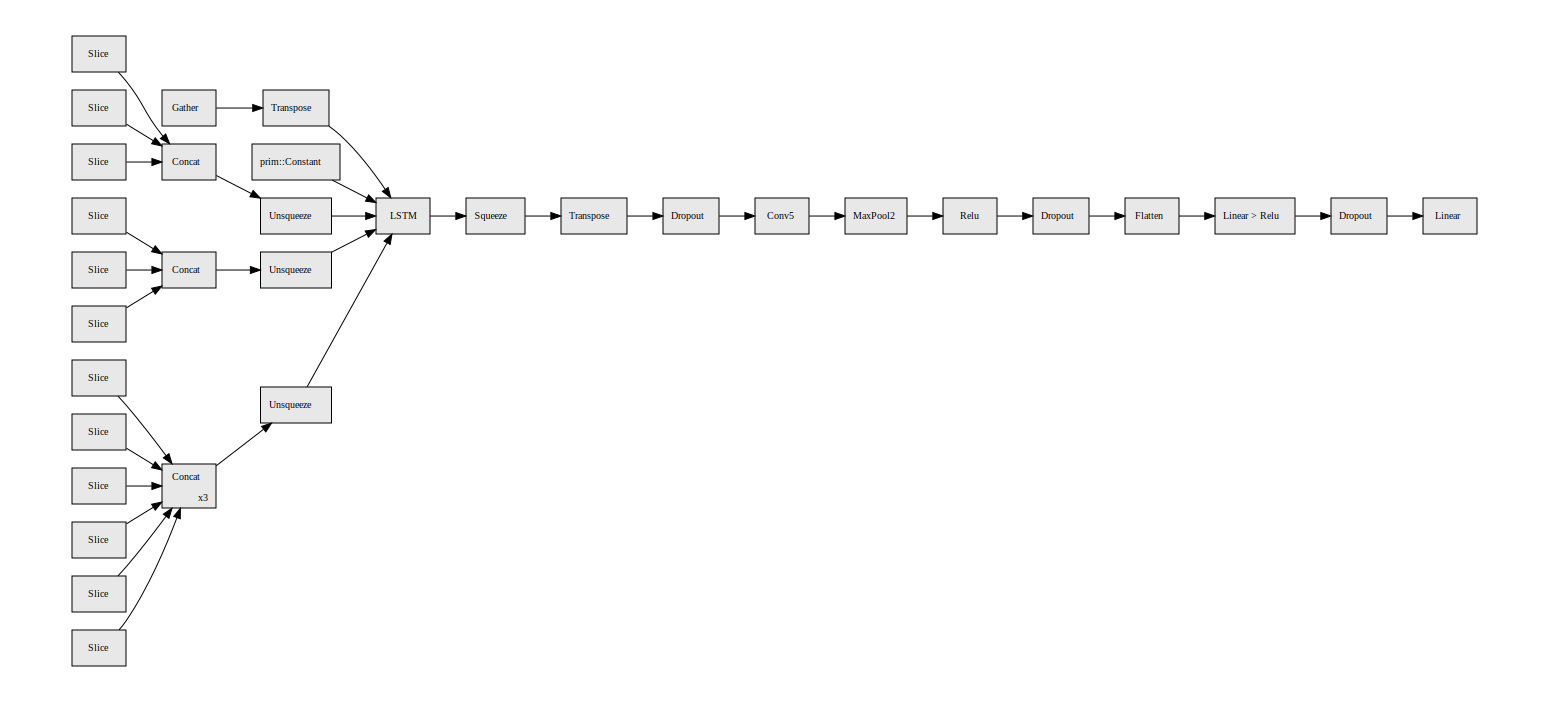

In [48]:
import hiddenlayer as hl

hl.build_graph(model, (torch.zeros([50, 32]).to(device).long(), (torch.zeros(1, 50, 32).to(device), torch.zeros(1, 50, 32).to(device))))


Train the LSTM neural network.

In [33]:
import time
from sklearn.metrics import accuracy_score

NUM_EPOCHS = 40

start=time.time()
train_losses = []
test_losses = []

for epoch in range(NUM_EPOCHS):

    h0, c0 =  model.init_hidden()

    h0 = h0.to(device)
    c0 = c0.to(device)

    # Train mode
    model.train()

    for batch_idx, batch in enumerate(train_dl):

        input, target = batch[0].to(device), batch[1].to(device)

        optimizer.zero_grad()
        with torch.set_grad_enabled(True):
            out, hidden = model(input, (h0, c0))
            train_loss = criterion(out, target.long())
            train_loss.backward()
            optimizer.step()

        pred = torch.argmax(out, dim=1)
        correct = torch.sum(torch.eq(pred, target)).item()

        elapsed = time.time() - start
        
        if not batch_idx % (math.ceil(len(train_dl) / 4)):
            print(f'epoch: {epoch}, batch: {batch_idx:<{len(str(len(train_dl)))}}/{len(train_dl)}, time: {elapsed:.3f}s, loss: {train_loss.item():.3f}, acc: {correct / BATCH_SIZE:.3f}')
    
    train_losses.append(train_loss.item())

    # Evaluation mode
    model.eval()

    batch_acc = []
    for batch_idx, batch in enumerate(test_dl):

        input, target = batch[0].to(device), batch[1].to(device)

        optimizer.zero_grad()
        with torch.set_grad_enabled(False):
            out, hidden = model(input, (h0, c0))
            _, preds = torch.max(out, 1)
            preds = preds.to(device).tolist()
            batch_acc.append(accuracy_score(preds, target.tolist()))

            test_loss = criterion(out, target.long())

    print(f'Accuracy on the test set: {sum(batch_acc)/len(batch_acc):.3f}')

    test_losses.append(test_loss.item())

torch.Size([50, 32])
epoch: 0, batch: 0  /411, time: 0.011s, loss: 1.096, acc: 0.420
torch.Size([50, 32])
torch.Size([50, 32])
torch.Size([50, 32])
torch.Size([50, 32])
torch.Size([50, 32])
torch.Size([50, 32])
torch.Size([50, 32])
torch.Size([50, 32])
torch.Size([50, 32])
torch.Size([50, 32])
torch.Size([50, 32])
torch.Size([50, 32])
torch.Size([50, 32])
torch.Size([50, 32])
torch.Size([50, 32])
torch.Size([50, 32])
torch.Size([50, 32])
torch.Size([50, 32])
torch.Size([50, 32])
torch.Size([50, 32])
torch.Size([50, 32])
torch.Size([50, 32])
torch.Size([50, 32])
torch.Size([50, 32])
torch.Size([50, 32])
torch.Size([50, 32])
torch.Size([50, 32])
torch.Size([50, 32])
torch.Size([50, 32])
torch.Size([50, 32])
torch.Size([50, 32])
torch.Size([50, 32])
torch.Size([50, 32])
torch.Size([50, 32])
torch.Size([50, 32])
torch.Size([50, 32])
torch.Size([50, 32])
torch.Size([50, 32])
torch.Size([50, 32])
torch.Size([50, 32])
torch.Size([50, 32])
torch.Size([50, 32])
torch.Size([50, 32])
torch.Size([

KeyboardInterrupt: 

## Save model

Save the trained model.  
Skip if you don't wish to save your lastly trained model.

In [13]:
path = "model/"
if not os.path.exists(path):
  os.makedirs(path)

torch.save(model.state_dict(), path + "model.pth")

## Load model

Load the saved model from `./model/model.pth`.  
Skip if you don't wish to load the lastly saved model.

In [14]:
path = "model/"
model = LSTM_Sentiment(len(word2index), 64, 32, 1, 0.2)
model.load_state_dict(torch.load(path + "model.pth"))
model = model.to(device)
model.eval()

LSTM_Sentiment(
  (embedding): Embedding(8516, 64, padding_idx=0)
  (lstm): LSTM(64, 32, batch_first=True)
  (conv): Conv1d(32, 16, kernel_size=(3,), stride=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=240, out_features=3, bias=True)
)

## Evaluation

Evaluate the trained model.

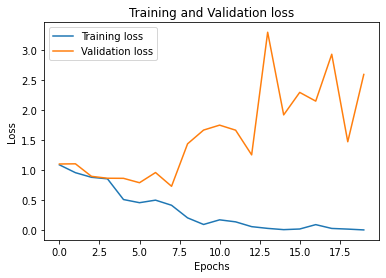

In [15]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label="Training loss")
plt.plot(test_losses, label="Validation loss")
plt.title("Training and Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [16]:
batch_acc = []
for batch_idx, batch in enumerate(test_dl):

    input, target = batch[0].to(device), batch[1].to(device)

    optimizer.zero_grad()
    with torch.set_grad_enabled(False):
        out, hidden = model(input, (h0, c0))
        _, preds = torch.max(out, 1)
        preds = preds.to(device).tolist()
        batch_acc.append(accuracy_score(preds, target.tolist()))

print(f'Final accuracy on the test set: {sum(batch_acc)/len(batch_acc):.3f}')

Final accuracy on the test set: 0.673


## Reddit API

Get Reddit posts and comments that corrospond to given keywords.

In [173]:
from auth import CLIENT_ID, SECRET_KEY, REDDIT_USERNAME, REDDIT_PASSWORD

import requests

auth = requests.auth.HTTPBasicAuth(CLIENT_ID, SECRET_KEY)

data = {
    "grant_type": "password",
    "username": REDDIT_USERNAME,
    "password": REDDIT_PASSWORD
}

headers = {"User-Agent": "MyAPI/0.0.1"}

res = requests.post("https://www.reddit.com/api/v1/access_token", auth=auth, data=data, headers=headers)

TOKEN = res.json()["access_token"]

headers["Authorization"] = f'bearer {TOKEN}'

requests.get("https://oauth.reddit.com/api/v1/me", headers=headers).json()

{'is_employee': False,
 'seen_layout_switch': False,
 'has_visited_new_profile': False,
 'pref_no_profanity': True,
 'has_external_account': False,
 'pref_geopopular': '',
 'seen_redesign_modal': False,
 'pref_show_trending': True,
 'subreddit': {'default_set': True,
  'user_is_contributor': False,
  'banner_img': '',
  'restrict_posting': True,
  'user_is_banned': False,
  'free_form_reports': True,
  'community_icon': None,
  'show_media': True,
  'icon_color': '',
  'user_is_muted': False,
  'display_name': 'u_Rubinjo_L',
  'header_img': None,
  'title': '',
  'coins': 0,
  'previous_names': [],
  'over_18': False,
  'icon_size': [256, 256],
  'primary_color': '',
  'icon_img': 'https://styles.redditmedia.com/t5_5ga0v8/styles/profileIcon_snoo7e1baabd-7daf-4774-a95d-92829e511322-headshot.png?width=256&amp;height=256&amp;crop=256:256,smart&amp;s=5bf6cac6695af43722caff15194db1958f1fc158',
  'description': '',
  'submit_link_label': '',
  'header_size': None,
  'restrict_commenting': Fa

In [174]:
from datetime import datetime

# Use company name, stock ticker and/or abbreviation of company
SEARCH = ["Apple", "AAPL"]

df_reddit = pd.DataFrame()

for term in SEARCH:
    payload = {"q": term, "limit": "5", "sort": "new"}

    res = requests.get("https://oauth.reddit.com/r/subreddits/search", headers=headers, params=payload)
    for post in res.json()["data"]["children"]:
        df_reddit = df_reddit.append({
            "subreddit": post["data"]["subreddit"],
            "postid": post["data"]["id"],
            "text": post["data"]["title"] + " " + post["data"]["selftext"],
            "created": datetime.fromtimestamp(post["data"]["created"])
        }, ignore_index=True)

df_reddit = df_reddit.drop_duplicates("postid", ignore_index=True)

for index, item in df_reddit.iterrows():
    payload = {"limit": "5", "sort": "new"}

    res = requests.get("https://oauth.reddit.com/r/" + item["subreddit"] + "/comments/" + item["postid"], headers=headers, params=payload)
    
    for comment in res.json()[1]["data"]["children"]:
        try:
            df_reddit = df_reddit.append({
                "subreddit": item["subreddit"],
                "text": comment["data"]["body"],
                "created": datetime.fromtimestamp(comment["data"]["created"])
            }, ignore_index=True)
        except:
            print(item["postid"] + " in the " + item["subreddit"] + " subreddit does not have enough comments.")
        
print("\nTop 3 subreddits used:")
print(df_reddit["subreddit"].value_counts()[:3])

df_reddit = df_reddit.drop(columns=["subreddit", "postid"])

rxeddx in the stocks subreddit does not have enough comments.
rxdv3o in the BizSMG subreddit does not have enough comments.

Top 3 subreddits used:
stocks          6
BizSMG          6
Kant_sleep13    4
Name: subreddit, dtype: int64


## Twitter API

Get tweets that corrospond to given keywords.

In [175]:
from auth import TWITTER_TOKEN

def auth():
    return TWITTER_TOKEN

def create_headers(bearer_token):
    headers = {"Authorization": "Bearer {}".format(bearer_token)}
    return headers

def create_url(keyword, max_results = 10):
    
    search_url = "https://api.twitter.com/2/tweets/search/recent"

    # Change params based on the endpoint you are using
    query_params = {'query': keyword,
                    'max_results': max_results,
                    'tweet.fields': 'id,text,author_id,created_at,lang,source',
                    'next_token': {}}
    return (search_url, query_params)

def connect_to_endpoint(url, headers, params, next_token = None):
    params['next_token'] = next_token   #params object received from create_url function
    response = requests.request("GET", url, headers = headers, params = params)
    print("Endpoint Response Code: " + str(response.status_code))
    if response.status_code != 200:
        raise Exception(response.status_code, response.text)
    return response.json()

# Inputs for the request
bearer_token = auth()
headers = create_headers(bearer_token)
keyword = "AAPL lang:en"
max_results = 10

url = create_url(keyword, max_results)
print(url)
json_response = connect_to_endpoint(url[0], headers, url[1])
df_twitter_dirty = pd.DataFrame.from_dict(json_response["data"])
df_twitter_dirty = df_twitter_dirty.drop(columns=["author_id", "source", "lang", "id"])

df_twitter = pd.DataFrame()

for index, item in df_twitter_dirty.iterrows():
    df_twitter = df_twitter.append({
                "text": item["text"],
                "created": datetime.fromisoformat(item["created_at"].replace("Z", ""))
            }, ignore_index=True)

('https://api.twitter.com/2/tweets/search/recent', {'query': 'AAPL lang:en', 'max_results': 10, 'tweet.fields': 'id,text,author_id,created_at,lang,source', 'next_token': {}})
Endpoint Response Code: 200


## Sentiment of collected data

Add data from Reddit and Twitter together and get the estimated sentiment from the trained NN. 

In [176]:
df_total_dirty = pd.concat([df_reddit, df_twitter], ignore_index=True)
df_total_dirty.head(10)

,text,created
0,Wider release for Thrashed Apple? I picked up ...,2022-01-06 16:19:30
1,Should I continue learning android development...,2022-01-06 16:19:05
2,[H] Student Beans Accounts one Year -$5 [W] Pa...,2022-01-06 16:18:30
3,"Apples, Oranges, battle lines. Mushroom cloud.",2022-01-06 16:15:50
4,"What are your days usually like, and how much ...",2022-01-06 16:15:11
5,"Stock Watch List January 6, 2022 ***Good morni...",2022-01-06 14:51:53
6,This Subs Environment is so Toxic on days the ...,2022-01-06 14:16:01
7,Top stock option open interest changes $AAPL $...,2022-01-06 13:58:42
8,Thu Jan 6 23:50:25 2022 NASDAQ:TSLA / 127\n\n[...,2022-01-06 13:50:25
9,$AAPL Awaiting Buy Signal. Chart by UltraAlgo....,2022-01-06 13:49:07


In [177]:
df_total = pd.DataFrame()

for index, item in df_total_dirty.iterrows():
    df_total = df_total.append({
        "encoded_text": encode_and_pad(tokenization(normalize_text(item["text"])), SEQ_LENGTH),
        "created": item["created"]
    }, ignore_index=True)

df_total.head(10)

,encoded_text,created
0,"[1, 0, 758, 14, 6320, 223, 194, 47, 370, 214, ...",2022-01-06 16:19:30
1,"[1, 494, 47, 776, 652, 74, 1910, 839, 494, 47,...",2022-01-06 16:19:05
2,"[1, 2626, 2180, 2627, 2205, 6761, 13, 34, 182,...",2022-01-06 16:18:30
3,"[1, 223, 44, 5043, 44, 1615, 1577, 57, 0, 4941...",2022-01-06 16:15:50
4,"[1, 159, 100, 121, 18, 765, 162, 44, 27, 277, ...",2022-01-06 16:15:11
5,"[1, 2976, 503, 1457, 2671, 915, 44, 0, 961, 96...",2022-01-06 14:51:53
6,"[1, 59, 5532, 0, 122, 124, 4561, 8, 18, 16, 0,...",2022-01-06 14:16:01
7,"[1, 552, 2976, 1704, 639, 2050, 289, 108, 6412...",2022-01-06 13:58:42
8,"[1, 8385, 1805, 915, 0, 0, 0, 77, 0, 904, 0, 2...",2022-01-06 13:50:25
9,"[1, 108, 6412, 0, 440, 4927, 57, 1220, 505, 0,...",2022-01-06 13:49:07


In [178]:
def label_map(label):
    if label == 0:
        return "negative"
    elif label == 1:
        return "neutral"
    else: #2
        return "positive"

df_labels = pd.DataFrame()

h0, c0 =  model.init_hidden(1)
h0 = h0.to(device)
c0 = c0.to(device)

optimizer.zero_grad()
with torch.set_grad_enabled(False):

    for index, item in df_total.iterrows():
        out, hidden = model(torch.tensor([item["encoded_text"]]).to(device), (h0, c0))
        _, preds = torch.max(out, 1)
        preds = preds.to(device).tolist()
        df_labels = df_labels.append({
            "label_cat": preds[0],
            "label": label_map(preds[0]),
            "created": item["created"]
        }, ignore_index=True)

df_labels["text"] = df_total_dirty["text"]

df_labels.head(10)

,label_cat,label,created,text
0,1.0,neutral,2022-01-06 16:19:30,Wider release for Thrashed Apple? I picked up ...
1,0.0,negative,2022-01-06 16:19:05,Should I continue learning android development...
2,2.0,positive,2022-01-06 16:18:30,[H] Student Beans Accounts one Year -$5 [W] Pa...
3,2.0,positive,2022-01-06 16:15:50,"Apples, Oranges, battle lines. Mushroom cloud."
4,1.0,neutral,2022-01-06 16:15:11,"What are your days usually like, and how much ..."
5,2.0,positive,2022-01-06 14:51:53,"Stock Watch List January 6, 2022 ***Good morni..."
6,1.0,neutral,2022-01-06 14:16:01,This Subs Environment is so Toxic on days the ...
7,1.0,neutral,2022-01-06 13:58:42,Top stock option open interest changes $AAPL $...
8,2.0,positive,2022-01-06 13:50:25,Thu Jan 6 23:50:25 2022 NASDAQ:TSLA / 127\n\n[...
9,2.0,positive,2022-01-06 13:49:07,$AAPL Awaiting Buy Signal. Chart by UltraAlgo....


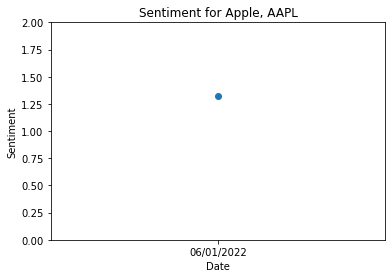

Average sentiment: 1.324


In [179]:
dates = []
df_result = pd.DataFrame()

for index, item in df_labels.iterrows():
    if item["created"].date() not in dates:
        dates.append(item["created"].date())

for date in dates:
    df_result = df_result.append({
        "sentiment": df_labels["label_cat"][df_labels["created"].apply(lambda date: date.date()) == date].mean(),
        "date": date.strftime('%d/%m/%Y')
    }, ignore_index=True)

plt.plot(df_result["date"].values.tolist(), df_result["sentiment"].values.tolist(), marker="o")
plt.ylim(0, 2)
plt.title("Sentiment for " + ", ".join(SEARCH))
plt.xlabel("Date")
plt.ylabel("Sentiment")
plt.show()

print(f'Average sentiment: {df_result["sentiment"].mean():.3f}')

## Yahoo Stock API

In [180]:
import yfinance as yf
import datetime

df['StartDate'] = pd.to_datetime(df_result['date'], format='%d/%m/%Y')
least_recent_date = df['StartDate'].min()
most_recent_date = df['StartDate'].max()
most_recent_date += datetime.timedelta(days=1)
end_date = most_recent_date.strftime('%Y-%m-%d')
start_date = least_recent_date.strftime('%Y-%m-%d')

apple = yf.Ticker("AAPL")
df_stock = apple.history(interval="1d", start=start_date, end=end_date)
df_stock = df_stock.drop( df_stock.index.to_list()[0] ,axis = 0 )
df_stock = df_stock.drop(["High", "Low", "Volume", "Dividends", "Stock Splits"], axis=1)
df_stock

,Open,Close
Date,,
2022-01-06,172.699997,173.065002


In [181]:
df_stock["stock_change"] = df_stock["Open"] - df_stock["Close"]
df_stock = df_stock.drop(["Open", "Close"], axis=1)
df_stock

,stock_change
Date,
2022-01-06,-0.365005


In [182]:
df_result["stock_change"] = df_stock["stock_change"].values.tolist()
df_result = df_result[["date", "sentiment", "stock_change"]]
df_result

,date,sentiment,stock_change
0,06/01/2022,1.323529,-0.365005
